## Setup

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# make the notebook executable on google colab
if 'google.colab' in str(get_ipython()):
    # install package
    try:
      import gsemantique
    except ImportError:
      !git clone https://github.com/fkroeber/gsemantique.git
      !cd gsemantique && pip install .
    # change working directory
    demo_dir = "gsemantique/demo"
    import os
    if not os.getcwd().endswith(demo_dir):
      os.chdir(demo_dir)
else:
    # get the logger to investigate the logs 
    import logging
    import sys
    logger = logging.getLogger("gsemantique.data.search")
    logger.setLevel(logging.INFO)
    stream_handler = logging.StreamHandler()
    logger.addHandler(stream_handler)

In [9]:
# general imports
import geopandas as gpd
import json
import matplotlib.pyplot as plt
import pandas as pd
from shapely.geometry import box

# semantique imports
import gsemantique as gsq
import semantique as sq
from gsemantique.data.datasets import DatasetCatalog
from gsemantique.data.download import Downloader
from gsemantique.data.search import Finder
from gsemantique.process.scaling import TileHandler, TileHandlerParallel
from gsemantique.process.utils import update_na, change_dtype

## Intro

Frequently, clouds are obscuring the actual entities of interest, i.e the Earth's surface. Therefore, filtering data for scenes with minimal cloud coverage is a common preprocessing step in many EO processing workflows. This notebook showcases how clouds can be filtered within semantic EO data cubes. 

Specifically, the notebook aims to demonstrate how the dedicated exclusion of clouds at the pixel-level using semantic querying leads to superior results in the downstream task of creating cloud-free composites when comparing this to a common alternative approach, the so-called median composite. In this conventional approach, the median value of a timeseries is used to likely capture a cloud-free one (since clouds are very bright and therefore most likely above the median). As such, the median compositing technqiue makes indirect assumptions on how clouds can be filtered based on their data-distribution related characteristica.

Note that the analyses presented below can be scaled up to multiannual, nation-wide computations. For the sake of demonstration, however, we will limit ourselves within this notebook to a two-month time period for the area of Vienna (NUTS-2 region).

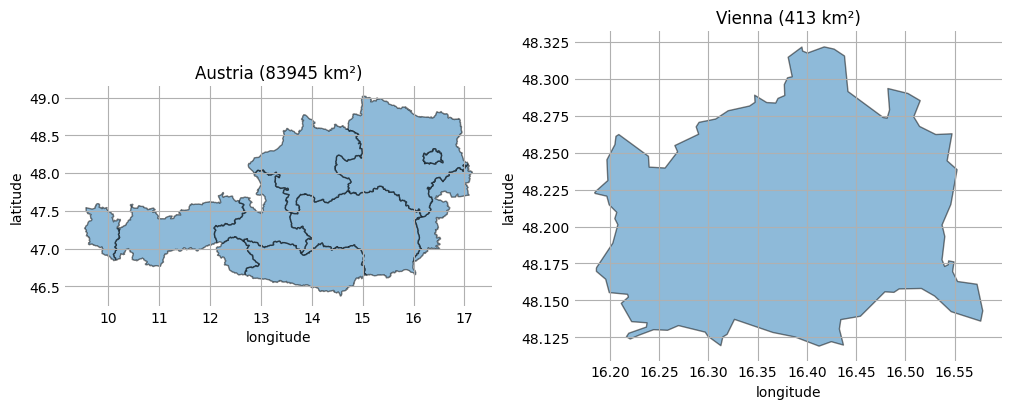

In [25]:
# read aois
at = gpd.read_file("files/austria.geojson")
vienna = at[geo_at["NUTS_NAME"] == "Wien"]

# plot aois
aois = {
    "Austria": at,
    "Vienna": vienna
}

fig, axs = plt.subplots(1, 2, figsize=(10,5), constrained_layout=True)
for i, (name,aoi) in enumerate(aois.items()):
    aoi_size = aoi.to_crs(3035).area.sum()/10**6
    aoi.to_crs(4326).plot(ax = axs[i], alpha=0.5, edgecolor="black")
    axs[i].set_title(f"{name} ({aoi_size:.0f} km²)")
    axs[i].set_frame_on(False)
    axs[i].grid(True)
    axs[i].set_ylabel("latitude")
    axs[i].set_xlabel("longitude")
    axs[i].tick_params(length=0)

Let us define the basic spatio-temporal context for this part first.

* cloud-free compositing -> relative comparison (areas with large differences probably clouds)
    * higher coverage & better quantification of uncertainty 
    * enables to demonstrate also possibility to use NA values
* evaluation
    * absolute evaluation of model difficult since ground truth for clouds would be needed 
    * instead: evaluate difference between different mosaics and threshold large differences as likely to be clouds
    * important: large absolute differences (i.e. reflectance-wise), otherwise vegetation/bare soil can also be detected
    * quantify difference & provide visual comparison

In [42]:
# define spatio-temporal extent
res = 20
epsg = 3035
t_start, t_end = '2022-07-01', '2022-09-01'
time = sq.TemporalExtent(pd.Timestamp(t_start), pd.Timestamp(t_end))
aoi = vienna.to_crs(4326)
space = sq.SpatialExtent(aoi)

# get gsemantiques layout file
package_dir = os.path.split(gsq.__file__)[0]
layout_path = os.path.join(package_dir, "data", "layout.json")

# load data catalog
ds_catalog = DatasetCatalog()
ds_catalog.load()

In [43]:
def model_cloudfree_composite(gran, interp, bands = ["s2_band04", "s2_band03", "s2_band02"]):
    """Model to create cloud-free composites of defined temporal granularity
    
    params:
        gran: temporal granularity, one of ["year"], ["month"], ["season"], ["quarter"] or a combination 
        interp: temporal interpolation method, one of "linear", "pchip"
        bands: list of bands to build the composite upon 
    
    notes:
        For the temporal granularity only disjunct/partionable combinations are feasible.
        E.g. ["year", "month"] can be used as granularity to get monthly cloudfree composites,
        whereas "season" doesn't work in conjunction with "year" as it spans several years.
    """ 

    # 0. parse arguments
    main_gran = gran[-1]
    if interp == "linear":
        min_valid = 2
        interp_kwargs = dict(bounds_error=False, fill_value="extrapolate")
    elif interp == "pchip":
        min_valid = 2
        interp_kwargs = dict(extrapolate=True)
    else:
        raise ValueError(f"{interp} not implemented as interpolation method.")

    recipe = sq.QueryRecipe()

    # 1. define mask of AoI values
    recipe["aoi_mask"] = (
        sq.layer(*bands[0])
        .evaluate("is_missing")
        .reduce("all", "time")
    )

    # 2. create basis composite as median of cloud-free images
    recipe["comp"] = (
        sq.collection(*[sq.layer(*x) for x in bands])
        .concatenate("band")
        .filter(sq.entity("cloud").evaluate("not"))
        .groupby_time(gran)
        .reduce("median", "time")
        .concatenate(main_gran)
    )

    # 3. get counts and filter them to have at least n valid observations
    recipe["comp_mask"] = (
        sq.result("comp")
        .evaluate("not_missing")
        .reduce("count", main_gran)
        .evaluate("less", min_valid)
    )

    # 4. interpolate with assignment of dummy vals to masked observations
    recipe["comp_interp"] = (
        sq.result("comp")
        .assign(0, at=sq.result("comp_mask"))
        .fill(main_gran, method=interp, use_coordinate=False, **interp_kwargs)
    )

    # 5. filter to valid observations
    recipe["comp_final"] = (
        sq.result("comp_interp")
        .assign(np.nan, at=sq.result("comp_mask"))
    )

    # 6. create median composite for reference
    recipe["comp_median"] = (
        sq.collection(*[sq.layer(*x) for x in bands])
        .concatenate("band")
        .groupby_time(gran)
        .reduce("median", "time")
        .concatenate(main_gran)
    )

    return recipe

In [47]:
class CfCreator:
    # define recipe
    gran="month"
    interp="linear"
    bands = [
        ("Planet", "reflectance", "s2_band08"),
        ("Planet", "reflectance", "s2_band04"),
        ("Planet", "reflectance", "s2_band03"),
        ("Planet", "reflectance", "s2_band02"),
    ]
    recipe = model_cloudfree_composite(gran, interp, bands)

    def __init__(self, layer_search_key, sat_mapping, cloud_thres, output_dir):
        """
        Search for cloud-free data based on metadata statistics of cloud coverage.

        Args:
            layer_search_key (tuple): The layer key to search for.
            sat_mapping (dict): The mapping specfic to the satellite data.
            cloud_thres (int): The cloud coverage threshold.
            output_dir (str): The output path to save the results.
        """
        self.layer_search_key = layer_search_key
        self.sat_mapping = sat_mapping
        self.cloud_thres = cloud_thres
        self.output_dir = output_dir

        self.fdr = None
        self.th = None

    def run(self):
        # search for data
        from shapely.geometry import Polygon
        bounds_df = aoi.to_crs(4326).bounds
        aoi['geometry'] = bounds_df.apply(lambda row: Polygon([
            (row['minx'], row['miny']), 
            (row['maxx'], row['miny']), 
            (row['maxx'], row['maxy']), 
            (row['minx'], row['maxy'])
        ]), axis=1)        
        self.fdr = Finder(ds_catalog, t_start, t_end, aoi.to_crs(4326).dissolve().geometry[0])

        with open(layout_path, "r") as file:
            dc = sq.datacube.STACCube(
            json.load(file), 
            src = [],
            )
        self.fdr.search_auto(
            CfCreator.recipe, 
            self.sat_mapping, 
            dc, 
            custom_verbs={"update_na": update_na, "change_dtype": change_dtype}
        )

        # filter by cloud cover
        stac_json = self.fdr.item_coll.to_dict()
        gdf = gpd.GeoDataFrame.from_features(stac_json, "epsg:4326")
        keep_idx = gdf[gdf["eo:cloud_cover"] <= self.cloud_thres].index.values
        item_coll = [x for idx, x in enumerate(self.fdr.item_coll) if idx in keep_idx]

        # construct datacube
        with open(layout_path, "r") as file:
            dc = sq.datacube.STACCube(
            json.load(file), 
            src = item_coll,
            group_by_solar_day=True,
            dask_params=None,
            )
     
        # create TileHandler instance & execute processing
        context = dict(
            recipe=CfCreator.recipe,
            datacube=dc,
            mapping=self.sat_mapping,
            space=space,
            time=time,
            spatial_resolution=[-res, res],
            crs=epsg,
            chunksize_s=1024,
            merge_mode="merged",
            out_dir=self.output_dir,
            reauth=True,
            custom_verbs={"update_na": update_na, "change_dtype": change_dtype}
        )
        self.th = TileHandler(**context)
        self.th.execute()

In [48]:
from datetime import datetime

# define sentinel mapping
s2_map = sq.mapping.Semantique()
s2_map["entity"] = {}
s2_map["entity"]["valid"] = {
    "color": sq.layer("Planet", "classification", "scl").evaluate("not_equal", 0)
}
s2_map["entity"]["cloud"] = {
    "color": sq.layer("Planet", "classification", "scl").evaluate("in", [8,9,10])
}

for sensor in ["sentinel"]:
    cfs = CfCreator(
        ("Planet", "classification", "scl"),
        s2_map,
        100,
        f"results/{sensor}_{datetime.now().strftime('%H%M%S')}"
    )
    cfs.run()

The recipe references the following data layers:
('Planet', 'reflectance', 's2_band03')
('Planet', 'reflectance', 's2_band02')
('Planet', 'reflectance', 's2_band08')
('Planet', 'classification', 'scl')
('Planet', 'reflectance', 's2_band04')
Initialise search for ('Planet', 'reflectance', 's2_band03')
Search started
Search finished
Search postprocessed
Found 45 datasets
Initialise search for ('Planet', 'reflectance', 's2_band02')
Search started
Search finished
Search postprocessed
Found 45 datasets
Initialise search for ('Planet', 'reflectance', 's2_band08')
Search started
Search finished
Search postprocessed
Found 45 datasets
Initialise search for ('Planet', 'classification', 'scl')
Search started
Search finished
Search postprocessed
Found 45 datasets
Initialise search for ('Planet', 'reflectance', 's2_band04')
Search started
Search finished
Search postprocessed
Found 45 datasets
creating spatial grid: 100%|██████████| 12/12 [00:00<00:00, 45.05it/s]
c:\users\felix\repositories\semantiq

The following numbers are rough estimations depending on the chosen strategy for merging the individual tile results. If merge='merged' is choosen the total size indicates a lower bound for how much RAM is required since the individual tile results will be stored in RAM before merging.

---------------------------------------
General layer info
---------------------------------------
layer       : dtype     crs   res      
---------------------------------------
aoi_mask    : float64   3035  [-20, 20]
comp        : float32   3035  [-20, 20]
comp_mask   : float64   3035  [-20, 20]
comp_interp : float64   3035  [-20, 20]
comp_final  : float64   3035  [-20, 20]
comp_median : float32   3035  [-20, 20]
---------------------------------------

------------------------------------------------
Scenario: 'merge' = None
------------------------------------------------
layer       :  size      tile n     tile shape  
------------------------------------------------
aoi_mask    : 0.02 Gb  11 tile(

executing recipe in tiled manner:   0%|          | 0/11 [00:00<?, ?it/s]c:\users\felix\repositories\semantique\semantique\processor\reducers.py:97: RuntimeWarning: All-NaN slice encountered
  return np.nanmedian(x, axis = axis)
c:\users\felix\repositories\semantique\semantique\processor\reducers.py:97: RuntimeWarning: All-NaN slice encountered
  return np.nanmedian(x, axis = axis)
c:\users\felix\repositories\semantique\semantique\processor\reducers.py:97: RuntimeWarning: All-NaN slice encountered
  return np.nanmedian(x, axis = axis)
c:\users\felix\repositories\semantique\semantique\processor\reducers.py:97: RuntimeWarning: All-NaN slice encountered
  return np.nanmedian(x, axis = axis)
executing recipe in tiled manner:   9%|▉         | 1/11 [00:09<01:36,  9.68s/it]c:\users\felix\repositories\semantique\semantique\processor\reducers.py:97: RuntimeWarning: All-NaN slice encountered
  return np.nanmedian(x, axis = axis)
c:\users\felix\repositories\semantique\semantique\processor\reducers